# import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.stem import WordNetLemmatizer
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
n = 1000

# Any results you write to the current directory are saved as output.

# Upload dataset

In [2]:
#df = pd.read_csv('metadata.csv')
bucket = 'coviddata'
file = 'metadata.csv'
gcs_url = 'https://%(bucket)s.storage.googleapis.com/%(file)s' % {'bucket':bucket, 'file':file}
df = pd.read_csv(gcs_url)

In [3]:
df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [4]:
df.shape

(44220, 15)

In [5]:
df.iloc[[10]]

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
10,60bf634cf15582a6b7f72eb3811ca5d8b8825c44,Elsevier,Determination of microsomal lauric acid hydrox...,10.1016/0003-2697(88)90093-0,NaN,3389520.0,els-covid,Abstract An assay for the microsomal hydroxyla...,1988-04-30,"Romano, Maria C.; Straub, Kenneth M.; Yodis, L...",Analytical Biochemistry,NaN,NaN,True,custom_license


# Remove duplicates and merge abstract and title

In [6]:
 # Some papers are duplicated since they were collected from separate sources
duplicate_paper = ~(df.title.isnull() | df.abstract.isnull()) & (df.duplicated(subset=['title', 'abstract']))
df = df[~duplicate_paper].reset_index(drop=True)

df = df.dropna(subset=['abstract'])

# create a column that appends title+abstract. This column will be the "document" that all searching/clustering/vectorization will use
df['document'] = df['title'] + '. ' + df['abstract']
print(df.shape)

(35443, 16)


In [7]:
df.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,document
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license,Intrauterine virus infections and congenital h...
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license,Clinical and immunologic studies in identical ...


# Drop unwanted columns

In [8]:
df = df.drop(columns = ['sha', 'source_x', 'pmcid', 'license', 'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text'])

In [9]:
df.head()

,title,doi,pubmed_id,abstract,publish_time,authors,journal,full_text_file,document
0,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,4361535.0,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,custom_license,Intrauterine virus infections and congenital h...
3,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,4579077.0,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,custom_license,Clinical and immunologic studies in identical ...
4,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,4014285.0,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,custom_license,Epidemiology of community-acquired respiratory...
5,Infectious diarrhea: Pathogenesis and risk fac...,10.1016/0002-9343(85)90367-5,2861742.0,Abstract Our understanding of the pathogenesis...,1985-06-28,"Cantey, J.Robert",The American Journal of Medicine,custom_license,Infectious diarrhea: Pathogenesis and risk fac...
6,New perspectives on the pathogenesis of rheuma...,10.1016/0002-9343(88)90356-7,3052052.0,Abstract In the pathogenesis of rheumatoid art...,1988-10-14,"Zvaifler, Nathan J.",The American Journal of Medicine,custom_license,New perspectives on the pathogenesis of rheuma...


In [10]:
df.shape

(35443, 9)

# Stop words list

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'see', 'figure', 'for', 'data','not', 'cleared','new', 'sentence', 'here','finally','also', 'could', 'thus', 'therefore','virus','infection','cell', 'protein','use','study','viral','disease','result','human'])

# Tokenize

In [12]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [41]:
# Convert to list
data = df.document.values.tolist()
#data


# get clean data

In [14]:
clean_words = df['document'].tolist()
clean_words[1]

'Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus. Abstract Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were evaluated for immunologic reactivity to previous antigenic challenges, including primary immunization with a foreign antigen, keyhole limpet hemocyanin (KLH). These two women had lived together for all of their 58 years and neither was receiving anti-inflammatory or immunosuppressive drugs at the time of these studies. Both twins demonstrated comparable 7S and 198 humoral antibody response to KLH, as well as similar viral antibody titers. However, the twin with SLE was anergic to common antigens, streptokinase-streptodornase, Trichophyton and Candida; furthermore delayed hypersensitivity to KLH did not develop after immunization. This observed discrepancy between humoral and cellular immunity in genetically similar subjects may be significant in the pathogenesis of SLE.'

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(clean_words))

print(data_words[:1])

[['intrauterine', 'virus', 'infections', 'and', 'congenital', 'heart', 'disease', 'abstract', 'the', 'etiologic', 'basis', 'for', 'the', 'vast', 'majority', 'of', 'cases', 'of', 'congenital', 'heart', 'disease', 'remains', 'largely', 'undefined', 'viruses', 'have', 'been', 'considered', 'to', 'be', 'likely', 'candidates', 'since', 'the', 'recognition', 'of', 'the', 'association', 'between', 'intrauterine', 'rubella', 'and', 'congenital', 'heart', 'disease', 'although', 'the', 'pathogenesis', 'of', 'cardiovascular', 'defects', 'is', 'poorly', 'understood', 'information', 'gained', 'from', 'the', 'study', 'of', 'congenital', 'rubella', 'syndrome', 'suggests', 'that', 'mechanisms', 'such', 'as', 'focal', 'endothelial', 'cell', 'damage', 'resulting', 'in', 'obliteration', 'of', 'vascular', 'supply', 'decreased', 'growth', 'rate', 'and', 'shortened', 'survival', 'time', 'of', 'certain', 'cells', 'and', 'disturbed', 'dna', 'replication', 'in', 'cells', 'whose', 'chromosomes', 'were', 'damage

In [16]:
from collections import Counter
from itertools import chain
import operator


print(str(len(data_words)) + ' total words in corpus')

counter_obj = Counter(chain.from_iterable(data_words))
word_counts = counter_obj.most_common()
word_counts.sort(key=operator.itemgetter(1), reverse=True)

word_counts[0:10]

35443 total words in corpus


[('the', 374891),
 ('of', 327993),
 ('and', 273058),
 ('in', 202820),
 ('to', 147136),
 ('for', 77202),
 ('with', 77038),
 ('that', 62064),
 ('is', 54007),
 ('were', 49302)]

# Creating Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['intrauterine', 'virus', 'infections', 'and', 'congenital_heart', 'disease', 'abstract', 'the', 'etiologic', 'basis', 'for', 'the', 'vast_majority', 'of', 'cases', 'of', 'congenital_heart', 'disease', 'remains', 'largely_undefined', 'viruses', 'have', 'been', 'considered', 'to', 'be', 'likely', 'candidates', 'since', 'the', 'recognition', 'of', 'the', 'association', 'between', 'intrauterine', 'rubella', 'and', 'congenital_heart', 'disease', 'although', 'the', 'pathogenesis', 'of', 'cardiovascular', 'defects', 'is', 'poorly_understood', 'information', 'gained', 'from', 'the', 'study', 'of', 'congenital', 'rubella', 'syndrome', 'suggests', 'that', 'mechanisms', 'such', 'as', 'focal', 'endothelial', 'cell', 'damage', 'resulting', 'in', 'obliteration', 'of', 'vascular', 'supply', 'decreased', 'growth', 'rate', 'and', 'shortened', 'survival', 'time', 'of', 'certain', 'cells', 'and', 'disturbed', 'dna', 'replication', 'in', 'cells', 'whose', 'chromosomes', 'were', 'damaged', 'secondary', 't

# Remove Stopwords, Make Bigrams and Lemmatize

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['intrauterine', 'infection', 'abstract', 'etiologic', 'basis', 'vast_majority', 'case', 'remain', 'largely_undefined', 'virus', 'consider', 'likely', 'candidate', 'association', 'intrauterine', 'rubella', 'pathogenesis', 'cardiovascular', 'defect', 'information', 'gain', 'congenital', 'rubella', 'syndrome', 'suggest', 'mechanism', 'focal', 'endothelial', 'damage', 'result', 'obliteration', 'vascular', 'supply', 'decrease', 'growth', 'rate', 'shorten', 'survival', 'time', 'certain', 'cell', 'disturb', 'dna', 'replication', 'cell', 'chromosome', 'damage', 'secondary', 'effect', 'replication', 'may', 'operative', 'production', 'defect', 'develop', 'fetus', 'addition', 'rubella', 'suggestive', 'conclusive', 'evidence', 'coxsackie', 'infection', 'pregnancy', 'birth', 'infant', 'variety', 'type', 'lesion', 'intrauterine', 'mump', 'may', 'etiologically', 'relate', 'postnatal', 'development', 'endocardial', 'fibroelastosis', 'efe', 'number', 'virus', 'potential', 'etiologic_agent', 'current'

# Create the Dictionary and Corpus needed for Topic Modeling

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 3), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 2), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1)]]


In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abnormal', 1),
  ('abstract', 1),
  ('addition', 1),
  ('agent', 1),
  ('allow', 1),
  ('animal', 1),
  ('appear', 1),
  ('area', 1),
  ('association', 2),
  ('basis', 1),
  ('birth', 1),
  ('candidate', 1),
  ('cardiovascular', 1),
  ('case', 1),
  ('causative', 1),
  ('cell', 2),
  ('certain', 1),
  ('chromosome', 1),
  ('conclusive', 1),
  ('congenital', 1),
  ('consider', 1),
  ('control', 1),
  ('coxsackie', 1),
  ('current', 1),
  ('damage', 2),
  ('decrease', 1),
  ('defect', 3),
  ('depend', 1),
  ('depth', 1),
  ('develop', 1),
  ('development', 2),
  ('disturb', 1),
  ('dna', 1),
  ('early', 1),
  ('efe', 1),
  ('effect', 1),
  ('effective', 1),
  ('endocardial', 1),
  ('endothelial', 1),
  ('epidemiology', 1),
  ('etiologic', 1),
  ('etiologic_agent', 1),
  ('etiologically', 1),
  ('even', 1),
  ('evidence', 1),
  ('fetus', 1),
  ('fibroelastosis', 1),
  ('focal', 1),
  ('future', 1),
  ('gain', 1),
  ('gestation', 1),
  ('growth', 1),
  ('identify', 1),
  ('inadequate',

#  Building the Topic Model

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"cell" + 0.027*"activity" + 0.021*"replication" + 0.019*"antiviral" + '
  '0.018*"receptor" + 0.016*"protein" + 0.014*"spread" + 0.013*"target" + '
  '0.012*"show" + 0.012*"cellular"'),
 (1,
  '0.079*"vaccine" + 0.055*"antibody" + 0.024*"response" + 0.023*"specific" + '
  '0.019*"recombinant" + 0.017*"epitope" + 0.016*"screen" + 0.016*"vector" + '
  '0.016*"candidate" + 0.015*"development"'),
 (2,
  '0.078*"sequence" + 0.050*"genome" + 0.029*"mutation" + 0.023*"strain" + '
  '0.017*"genomic" + 0.017*"cluster" + 0.014*"analysis" + 0.013*"dna" + '
  '0.012*"encode" + 0.012*"isolate"'),
 (3,
  '0.023*"structure" + 0.022*"domain" + 0.019*"bind" + 0.018*"site" + '
  '0.017*"region" + 0.015*"protein" + 0.013*"structural" + 0.012*"reveal" + '
  '0.011*"identify" + 0.011*"suggest"'),
 (4,
  '0.044*"gene" + 0.040*"host" + 0.036*"virus" + 0.022*"identify" + '
  '0.017*"use" + 0.016*"specie" + 0.015*"study" + 0.014*"include" + '
  '0.012*"genetic" + 0.012*"different"'),
 (5,
  '0.04

# Compute Model Perplexity and Coherence Score

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.291155924537744

Coherence Score:  0.5416819148439141


# LSA and LDA

In [25]:
from gensim import models, corpora
NUM_TOPICS = 20
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)
 


 

In [26]:
from gensim import models, corpora
NUM_TOPICS = 10
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)

In [27]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)
 

LDA Model:
Topic #0: 0.034*"structure" + 0.019*"interaction" + 0.018*"target" + 0.015*"bind" + 0.013*"system" + 0.013*"base" + 0.013*"function" + 0.012*"structural" + 0.011*"complex" + 0.010*"protein"
Topic #1: 0.056*"strain" + 0.037*"isolate" + 0.023*"pig" + 0.018*"ace" + 0.015*"prrsv" + 0.013*"variant" + 0.011*"porcine" + 0.008*"tissue" + 0.008*"cause" + 0.008*"gene"
Topic #2: 0.058*"membrane" + 0.023*"protein" + 0.021*"plant" + 0.019*"transport" + 0.017*"cap" + 0.014*"dataset" + 0.012*"vesicle" + 0.012*"complex" + 0.010*"pro" + 0.010*"ca"
Topic #3: 0.025*"sequence" + 0.019*"gene" + 0.018*"virus" + 0.016*"genome" + 0.014*"host" + 0.010*"protein" + 0.009*"analysis" + 0.009*"identify" + 0.009*"mutation" + 0.007*"region"
Topic #4: 0.018*"treatment" + 0.014*"bacterial" + 0.010*"clinical" + 0.009*"patient" + 0.008*"infection" + 0.007*"cause" + 0.007*"antibiotic" + 0.007*"bacteria" + 0.006*"diagnosis" + 0.006*"acute"
Topic #5: 0.046*"cell" + 0.019*"expression" + 0.016*"induce" + 0.015*"res

In [28]:


# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score LSA: ', coherence_lsi)


Coherence Score LSA:  0.4257718471852606


In [29]:
# Compute Perplexity
print('\nPerplexity LDA: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDA: ', coherence_lda)


Perplexity LDA:  -8.954917218188777

Coherence Score LDA:  0.5202155478841358


# Visualize the topics-keywords

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.155351 -0.067036       1        1  12.293459
3     -0.142374  0.013932       2        1   9.946188
9      0.012604  0.197973       3        1   9.503343
7      0.120837  0.171197       4        1   8.129057
16     0.215069  0.028683       5        1   7.833134
11     0.073193 -0.007222       6        1   5.787144
15     0.053116  0.085825       7        1   5.442680
4      0.088078  0.046517       8        1   5.116882
14    -0.197089 -0.044884       9        1   4.894404
17     0.004954 -0.014722      10        1   4.875417
6     -0.067019  0.064387      11        1   4.346781
10     0.062465  0.010493      12        1   4.208969
0     -0.198444  0.170562      13        1   3.367321
19     0.150417 -0.157725      14        1   3.008637
12     0.142062 -0.046454      15        1   2.729595
1      0.004675 -0.146956      16        1   2.714505
13    -0.067172 -0.113432      17        1   2.656727
18     0.102276  0.047460      18        1   1.371813
2     -0.223307 -0.026093      19        1   1.141731
8      0.021010 -0.212507      20        1   0.632211, topic_info=     Category          Freq       Term         Total  loglift  logprob
15    Default  23943.000000       cell  23943.000000  30.0000  30.0000
216   Default  21065.000000    patient  21065.000000  29.0000  29.0000
100   Default  10700.000000    vaccine  10700.000000  28.0000  28.0000
2515  Default  12726.000000     health  12726.000000  27.0000  27.0000
367   Default   8391.000000     strain   8391.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
1574  Topic20    202.086197     measle    509.538086   4.1389  -4.6328
2333  Topic20    251.293564       male    887.627258   3.8018  -4.4149
5204  Topic20    174.736130  expansion    531.998108   3.9503  -4.7782
927   Topic20    234.170746      blood   2804.188232   2.5809  -4.4854
229   Topic20    119.008476     specie   4481.303223   1.4352  -5.1623

[1599 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
974      10  0.019332        abort
974      14  0.966621        abort
3705      1  0.956980     abrogate
3705      2  0.039690     abrogate
8762      4  0.993996  absenteeism
...     ...       ...          ...
677       7  0.004929           μm
677       8  0.078859           μm
677      11  0.867452           μm
677      16  0.004929           μm
677      19  0.004929           μm

[8485 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 10, 8, 17, 12, 16, 5, 15, 18, 7, 11, 1, 20, 13, 2, 14, 19, 3, 9])

# Gensim offers a simple way of performing similarity queries using topic models.

In [31]:
from gensim import similarities
lda_index = similarities.MatrixSimilarity(lda_model[corpus])







In [32]:
from nltk import word_tokenize
STOPWORDS = stopwords.words('english')
def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text

In [33]:
text = 'What is known about transmission, incubation, and environmental stability'

In [34]:


bow = id2word.doc2bow(clean_text(text))
# Let's perform some queries
similarities = lda_index[lda_model[bow]]
# Sort the similarities
similarities = sorted(enumerate(similarities), key=lambda item: -item[1])

In [35]:
# Top most similar documents:
print(similarities[:10])

[(31060, 0.99443144), (30478, 0.97886586), (26343, 0.9767873), (18069, 0.9746246), (34907, 0.97419983), (20532, 0.96696925), (33043, 0.9663186), (9366, 0.96551967), (12000, 0.95778835), (3382, 0.9570763)]


In [36]:
df.iloc[1]

title             Clinical and immunologic studies in identical ...
doi                                    10.1016/0002-9343(73)90176-9
pubmed_id                                               4.57908e+06
abstract          Abstract Middle-aged female identical twins, o...
publish_time                                             1973-08-31
authors           Brunner, Carolyn M.; Horwitz, David A.; Shann,...
journal                            The American Journal of Medicine
full_text_file                                       custom_license
document          Clinical and immunologic studies in identical ...
Name: 3, dtype: object

# Topic Similarity results for queries

In [38]:
document_id_list=[]
for x in range(0, 3):
    document_id, similarity = similarities[x]
    document_id_list.append(document_id)
df.iloc[document_id_list]

#df.drop(columns = ['sha', 'source_x', 'pmcid', 'license', 'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text'])

,title,doi,pubmed_id,abstract,publish_time,authors,journal,full_text_file,document
39116,Using heterogeneity in the population structur...,10.1101/017178,NaN,"In 2013, U.S. swine producers were confronted ...",2016-02-11,Eamon B O'Dea;Harry Snelson;Shweta Bansal;,NaN,biorxiv_medrxiv,Using heterogeneity in the population structur...
38405,"Space-time clustering of, and risk factors for...",NaN,NaN,We used two statistical techniques for space-t...,NaN,"White, Maurice E.; Schukken, Ynte Hein; Tanksl...",NaN,NaN,"Space-time clustering of, and risk factors for..."
33419,Unravelling transmission trees of infectious d...,10.1098/rspb.2011.0913,NaN,Knowledge on the transmission tree of an epide...,NaN,"Ypma, R. J. F.; Bataille, A. M. A.; Stegeman, ...",NaN,NaN,Unravelling transmission trees of infectious d...


# Word Clouds of Top N Keywords in Each Topic

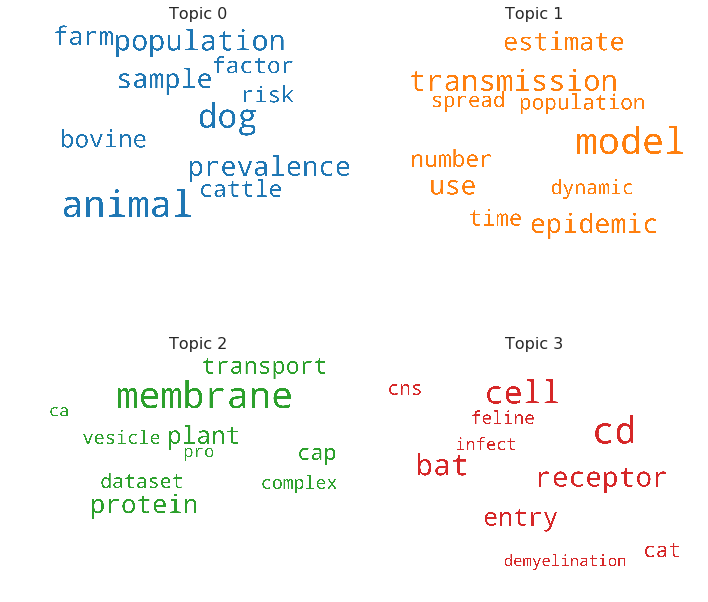

In [39]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

In [40]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2671,"disease, infectious, emerge, review, pathogen,...","[intrauterine, infection, abstract, etiologic,..."
1,1,13.0,0.4525,"cd, cell, bat, receptor, entry, cat, cns, feli...","[clinical, discordant, abstract, middle, age, ..."
2,2,10.0,0.3172,"child, infection, respiratory, rsv, cause, acu...","[epidemiology, respiratory, tract, infection, ..."
3,3,9.0,0.3541,"disease, infectious, emerge, review, pathogen,...","[infectious, diarrhea, pathogenesis, risk, fac..."
4,4,5.0,0.3481,"cell, expression, induce, response, mouse, rep...","[perspective, pathogenesis, abstract, pathogen..."
5,5,9.0,0.3373,"disease, infectious, emerge, review, pathogen,...","[acute, chronic, respiratory, tract, infection..."
6,6,4.0,0.3976,"treatment, bacterial, clinical, patient, infec...","[acute, bronchitis, result, european, trial, a..."
7,7,6.0,0.5670,"activity, drug, antiviral, use, compound, inhi...","[determination, lauric, acid, hydroxylase, act..."
8,8,0.0,0.3431,"structure, interaction, target, bind, system, ...","[vesicle, contain, bovine, heart, mitochondria..."
9,9,3.0,0.2180,"sequence, gene, virus, genome, host, protein, ...","[oligomeric, renal, aminopeptidase, membrane, ..."


In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()